In [1495]:
import netket as nk
import matplotlib.pyplot as plt
import numpy as np
from netket.operator.spin import sigmax,sigmaz,sigmay,identity,sigmam,sigmap   
import flax
import jax
import jax.numpy as jnp
import flax.linen as nn
from scipy.sparse.linalg import eigsh 
from netket import nn as nknn
from Methods.class_WF import Diag
import Methods.class_WF as class_WF
import Methods.var_nk as var_nk
import os
os.environ["JAX_ENABLE_X64"] = "True"
import matplotlib as mpl
import numpy as np
import sys
import pandas as pd
import equinox as eqx
import os
import json
from matplotlib import cm
import matplotlib as mp
import matplotlib.colors as mcolors
import scipy.special as sc
import scipy.optimize as so
from matplotlib.colors import LinearSegmentedColormap
from functools import reduce
from scipy.sparse import triu
from netket.operator.spin import identity

In [1496]:
#DEFINE FUNCTIONS:

In [1497]:
from Methods.class_WF import rotated_sigmax, rotated_sigmaz,isigmay,rotated_IsingModel,rotated_LONGIsingModel,rotated_BROKEN_Z2IsingModel,rotated_CIMModel_2
from Methods.class_WF import rotated_XYZModel, parity_Matrix, parity_IsingModel, Sz0Szj, Sx0Sxj, to_array, rotated_m, rotated_CIMModel, rotated_CIMModel_Y

In [1498]:
def GET_PROB_RBM(hi,param_RBM,j):
    
    #DEFINE THE PARAMETERS OF THE RBM
    AA=np.array(param_RBM["params"]["Dense"]["kernel"]["value"]["real"][j])+1j*np.array(param_RBM["params"]["Dense"]["kernel"]["value"]["imag"][j])
    BB=np.array(param_RBM["params"]["Dense"]["bias"]["value"]["real"][j])+1j*np.array(param_RBM["params"]["Dense"]["bias"]["value"]["imag"][j])
    CC=np.array(param_RBM["params"]["visible_bias"]["value"]["real"][j])+1j*np.array(param_RBM["params"]["visible_bias"]["value"]["imag"][j])
    
    #DEFINE THE STATES
    states=hi.all_states()
    
    #AUXILIAR MATRIX
    DD=np.tile(BB,(len(states),1))
    
    #COMPUTE THE PROBABILITIES
    
    logKK=states@CC
    log_AMP=np.log(np.cosh(states@AA+DD))
    log_ALMOST_PROB=np.sum(log_AMP,axis=-1)+logKK
    log_NORM=log_ALMOST_PROB+np.conjugate(log_ALMOST_PROB)
    NORM=np.sqrt(np.sum(np.exp(log_NORM)))
    
    PROB=np.exp(log_ALMOST_PROB)/NORM
    #------------------------------
    #KK=np.exp(states@CC)
    #AMP=np.cosh(states@AA+DD)
    #ALMOST_PROB=KK*np.prod(AMP,axis=-1)
    
    #NORMALIZE THE PROBABILITY
    #NORM=np.sqrt(ALMOST_PROB@np.conjugate(ALMOST_PROB))
    #PROB=ALMOST_PROB/NORM
    
    return PROB


In [1499]:
#DEFINE THE VARIABLES:

In [1565]:
L=10
G=100
DG=0.01
NN=1
NL=1
NR=500
learning_rate=0.05
basis="QIM"
modelo="RBM_COMPLEX"
##########################
angle=0
Nangle=12
dangle=np.pi/(2*Nangle)
NSPCA=100
NM=10
##########################
SAMPLER="FULL \; SUMMATION"
DS=1.0
add=r"$"+SAMPLER+r"\;\epsilon="+str(0.1*DS)+"$"
adder="SHIFT"+str(DS)
#adder="DS"+str(DS)
#adder=""
MASTER_DIR="FULL_STATE_RUN_"+basis+"_"+modelo+"NN"+str(NN)+"L"+str(L)+"G"+str(G)+"NA"+str(Nangle)+"NSPCA"+str(NSPCA)+adder
Nstates=2**L
eps=10**(-10)
angle=[dangle*i for i in range(Nangle+1)]
num_states=[i for i in range(2**L)]
labels=[r"$"+str(i)+r"\times\frac{\pi}{"+str(2*Nangle)+"}"+"$" for i in range(Nangle+1)]
if os.path.isdir(MASTER_DIR+" "):
    print("DIRECTORY NOT FOUND")
else:
    print("DIRECTORY ALREADY CREATED")
OBS_FILENAME="NANGLE"+str(Nangle)+basis+"M3L"+str(L)+"W1"+"G"+str(G)+"NN"+str(NN)+"NL"+str(NL)+"NR"+str(NR)+"OBS"
SPCA_FILENAME="NANGLE"+str(Nangle)+basis+"M3L"+str(L)+"W1"+"G"+str(G)+"NN"+str(NN)+"NL"+str(NL)+"NR"+str(NR)+"SPCA"
VAR_FILENAME="NANGLE"+str(Nangle)+basis+"M3L"+str(L)+"W1"+"G"+str(G)+"NN"+str(NN)+"NL"+str(NL)+"NR"+str(NR)+"VAR"

DIRECTORY ALREADY CREATED


<>:17: SyntaxWarning: invalid escape sequence '\;'
<>:17: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_16720/2882389147.py:17: SyntaxWarning: invalid escape sequence '\;'
  SAMPLER="FULL \; SUMMATION"


In [1566]:
norm = mcolors.Normalize(vmin=np.abs(0), vmax=1)
colors = [(0.0, 'yellow'),(0.25, "green"),(0.5, 'blue'),(0.75,"brown"),(1.0, 'red')]
cmap = LinearSegmentedColormap.from_list('custom_blue_green', colors)

In [1567]:
#EXACT DIAGONALIZATION AND COMPUTING THE ORDER PARAMETER

In [1568]:
#SOLUTION OF THE ISING MODEL AS A FUNCTION OF THETA:

In [1569]:
#SOLUTION OF THE ISING MODEL AND ITS PARAMETERS...

In [1570]:
S_PCA_TEO=[0.0 for i in angle]
PSI_TEO=[None for i in angle]
EXC_PSI_TEO=[None for i in angle]
N_pos=[0.0 for i in range(Nangle+1)]
mean_sign=[0.0 for i in range(Nangle+1)]
E_wsgn=[0.0 for i in range(Nangle+1)]
hi=nk.hilbert.Spin(s=1/2,N=L)
states=hi.all_states()
eps=10**(-10)
Pplus=None
Pminus=None
for theta in range(len(angle)):
    #PSI AND DIAGONALIZATION
    H=rotated_IsingModel(angle[theta],G*DG,L,hi)
    P=parity_IsingModel(np.pi/2.0,L,hi)
    Pplus=(identity(hi)+P)/2.0
    Pminus=(identity(hi)-P)/2.0
    #H=rotated_BROKEN_Z2IsingModel(angle[theta],G*DG,L,hi)
    #H=rotated_CIMModel_Y(angle[theta],G*DG,L,hi)
    #H=rotated_CIMModel_2(angle[theta],G*DG,L,hi)
    eig_vals_other,eig_vecs_other=np.linalg.eigh(H.to_dense())
    #eig_vals_other,eig_vecs_other=eigsh(H.to_sparse())
    print(eig_vals_other[0],eig_vals_other[1])
    
    PSI_TEO[theta]=eig_vecs_other[:,0]
    EXC_PSI_TEO[theta]=eig_vecs_other[:,100]
    if PSI_TEO[theta][0]<0:
        PSI_TEO[theta]=(-1.0)*PSI_TEO[theta]
        
    print(PSI_TEO[theta]@EXC_PSI_TEO[theta])
   # A=np.random.choice(num_states,size=1000,p=eig_vecs_other[:,0]**2)
   # B=np.array([states[a] for a in A])
    #S_PCA_TEO[theta]=class_WF.S_PCA(B,10**(-10),exvar=False)
    #SIGN PROBLEM
    
    #zeros=np.sum(np.abs(np.array(PSI_TEO[theta]))<eps)*1.0
    #mean_sign[theta]=(np.sum((np.array(PSI_TEO[theta])>eps)*1.0)+zeros)/2**(L)
    aux_wf=np.array(PSI_TEO[theta])
    
    aux_wf_ws=np.array(np.abs(PSI_TEO[theta]))
    
    mean_sign[theta]=np.sum(aux_wf*aux_wf*np.sign(aux_wf))
    E_wsgn[theta]= np.abs((aux_wf_ws.T@H.to_dense()@aux_wf_ws-eig_vals_other[0])/eig_vals_other[0])
    
    #H_array=to_array(H)*1.0
    #off_diag_indices=np.triu_indices(2**(L),k=1)
    #aux_1=H_array[off_diag_indices]
    #aux_2=aux_1[np.abs(aux_1)>eps]
    #N_pos[theta]=np.sum((aux_2>eps)*1.0)

    #SIGN PROBLEM SPARSE VERSION
    H_triu = triu(H.to_sparse(), k=1)
    # Get the data and row/col indices of non-zero entries
    data = H_triu.data
    # Filter elements with absolute value > eps
    mask = np.abs(data) > eps
    filtered_data = data[mask]
    # Count how many are > eps (i.e., positive and above threshold)
    N_pos[theta] = np.sum(filtered_data > eps)
    print("step",theta,"done")
    
sisj_z=[ PSI_TEO[0].T@Sz0Szj(0.0,L,hi,j).to_dense()@PSI_TEO[0] for j in [1,int(L/2),L-1]]
sisj_x=[ PSI_TEO[0].T@Sx0Sxj(0.0,L,hi,j).to_dense()@PSI_TEO[0] for j in [1,int(L/2),L-1]]

Pplus=Pplus.to_dense()
Pminus=Pminus.to_dense()


-12.381489999654743 -12.082569625309048
-7.112366251504909e-17
step 0 done
-12.381489999654754 -12.082569625309059
-1.8214596497756474e-17
step 1 done
-12.381489999654756 -12.082569625309057
-8.673617379884035e-18
step 2 done
-12.38148999965475 -12.082569625309057
-2.3418766925686896e-17
step 3 done
-12.381489999654749 -12.082569625309054
3.469446951953614e-18
step 4 done
-12.381489999654754 -12.082569625309054
3.469446951953614e-17
step 5 done
-12.381489999654752 -12.082569625309056
2.168404344971009e-17
step 6 done
-12.381489999654757 -12.082569625309054
4.163336342344337e-17
step 7 done
-12.381489999654752 -12.08256962530906
2.6020852139652106e-17
step 8 done
-12.38148999965475 -12.082569625309043
-5.2909066017292616e-17
step 9 done
-12.381489999654757 -12.082569625309048
-2.5153490401663703e-17
step 10 done
-12.381489999654752 -12.082569625309059
-1.951563910473908e-17
step 11 done
-12.381489999654749 -12.082569625309059
-3.426685795879641e-18
step 12 done


In [1571]:
# INITIALIZE NETKET TOOLS
sites_corr=[1,int(L/2),L-1]
sites_corr=[str(x) for x in sites_corr]
E=[[[0.0 for k in range(NR)]  for i in range(len(angle))] for rep in range(NM)]
dE=[[[0.0 for k in range(NR)] for i in range(len(angle))] for rep in range(NM)]
P=[[[0.0 for k in range(NR)] for i in range(len(angle))] for rep in range(NM)]
dP=[[[0.0 for k in range(NR)] for i in range(len(angle))] for rep in range(NM)]

indexes=[[[(rep,i,k) for k in range(NR)] for i in range(len(angle))] for rep in range(NM)]
indexes_S=[[[(rep,i,k) for k in range(NSPCA+1)] for i in range(len(angle))] for rep in range(NM)]

CZ=[[[None for corr in sites_corr] for i in range(len(angle))] for rep in range(NM)]
dCZ=[[ [None for corr in sites_corr] for i in range(len(angle))] for rep in range(NM)]

CX=[[ [None for corr in sites_corr] for i in range(len(angle))] for rep in range(NM)]
dCX=[[ [None for corr in sites_corr] for i in range(len(angle))] for rep in range(NM)]

data_RBM=[[[0.0 for k in range(NR)] for i in range(len(angle))] for rep in range(NM)]
data=[[None for i in range(len(angle))] for rep in range(NM)]

# Load the data from the JSON file
for rep in range(NM):
    for ii in range(len(angle)):
    
        with open(MASTER_DIR+"/"+str(rep)+"NM"+str(ii)+OBS_FILENAME+".json", "r") as f:
            data_RBM[rep][ii] = json.load(f)
        with open(MASTER_DIR+"/"+str(rep)+"NM"+str(ii)+VAR_FILENAME+".json", "r") as f:
            data[rep][ii] = json.load(f)

        E[rep][ii]=np.real(data_RBM[rep][ii]["Energy"]["Mean"]["real"])
        dE[rep][ii]=np.real(data_RBM[rep][ii]["Energy"]["Variance"])
  
    
        #for xi in range(len(sites_corr)):
        #    CZ[rep][ii][xi]=np.real(data_RBM[rep][ii]["CZ0"+sites_corr[xi]]["Mean"])
        #    dCZ[rep][ii][xi]=np.real(data_RBM[rep][ii]["CZ0"+sites_corr[xi]]["Sigma"])
        #    CX[rep][ii][xi]=np.real(data_RBM[rep][ii]["CX0"+sites_corr[xi]]["Mean"])
        #    dCX[rep][ii][xi]=np.real(data_RBM[rep][ii]["CX0"+sites_corr[xi]]["Sigma"])

#print(np.array(E) == None)

E=np.array(E)
dE=np.array(dE)
#S=np.array(S)
indexes=np.array(indexes)
Nones=[tuple(x) for x in indexes[E==None]]
for Nones_index in Nones:
    E[Nones_index]=0.001
#for None_index in Nones_S:
#    S[Nones_index]=0.001
E_RBM=np.array(E.copy())
E_all=np.array(E.copy())
E_all=np.abs((E_all-eig_vals_other[0])/eig_vals_other[0])
E_all[E_all>1.0]=1.0

X=np.array(data_RBM[0][0]["Energy"]["iters"])+1.0


In [1572]:
AA=[i for i in range(Nangle+1)]
NMM=[[kk for kk in range(NM)] for i in range(Nangle+1)]


In [1573]:
AA

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_16720/2210885000.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+r"\;"+r"\theta="+str(round(i/(2*Nangle),2))+"\pi\;\epsilon="+str(round(DS*0.1,1))+"$"+"\n"+"METROPOLIS HAMILTONIAN SAMPLER",fontsize=15)


(10, 13, 500)


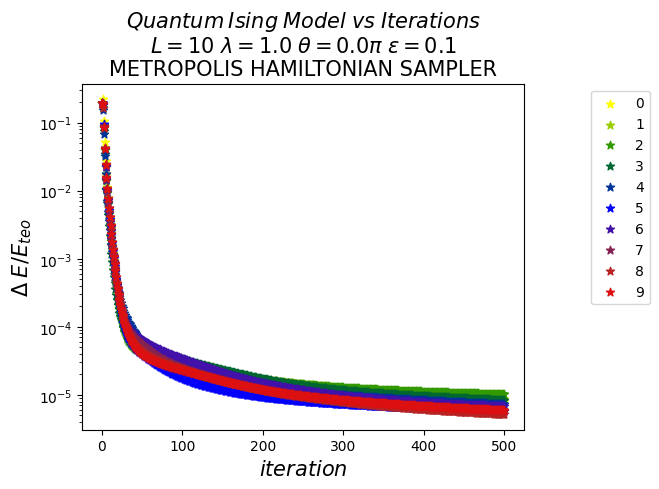

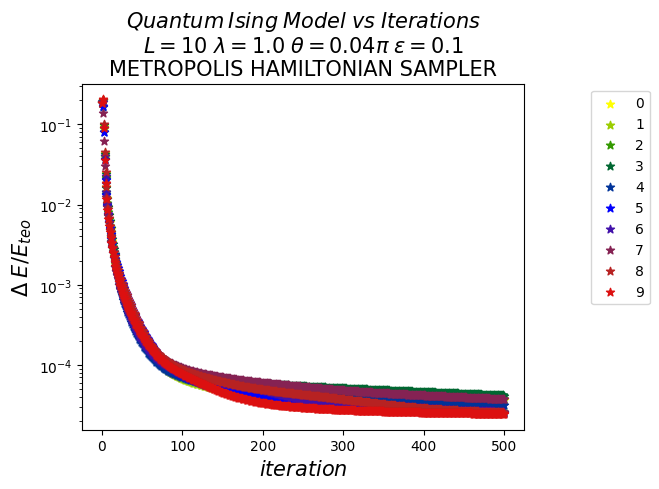

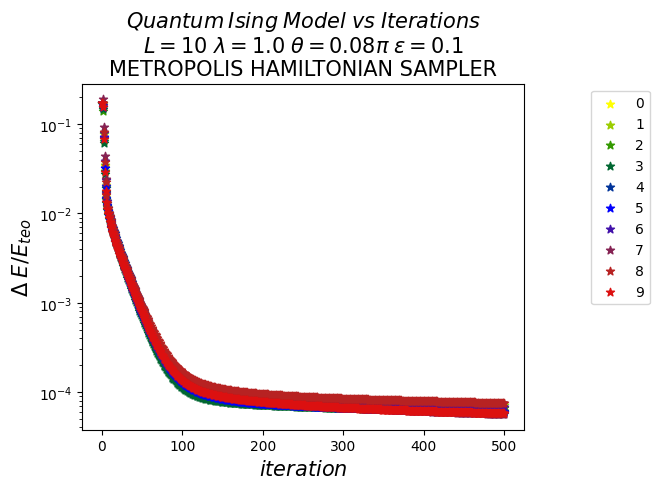

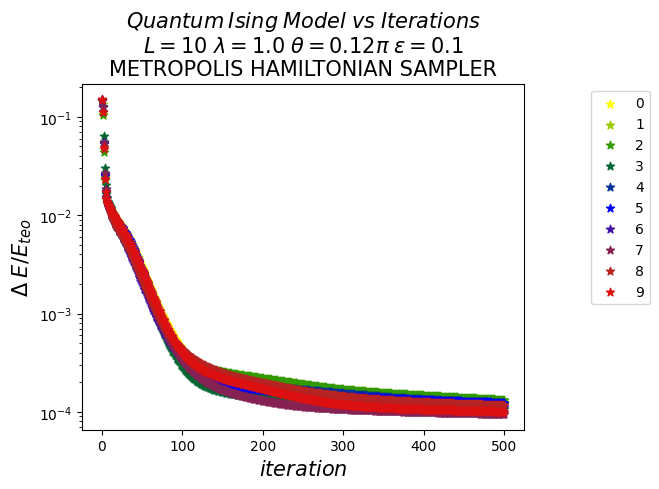

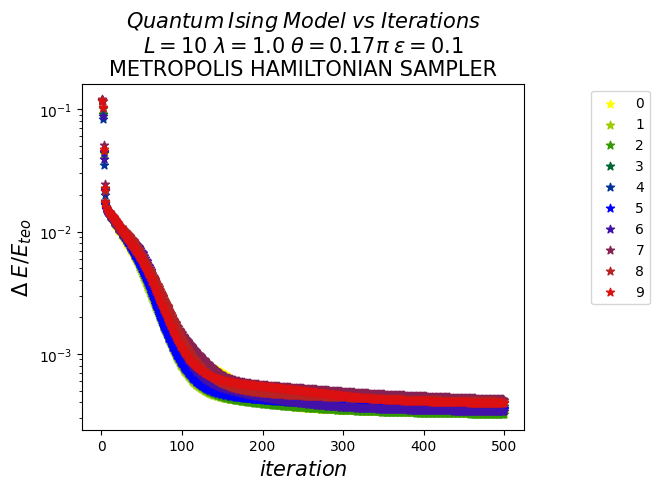

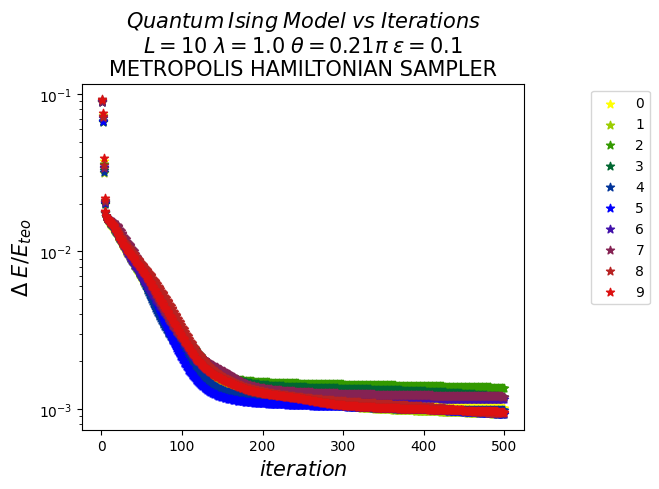

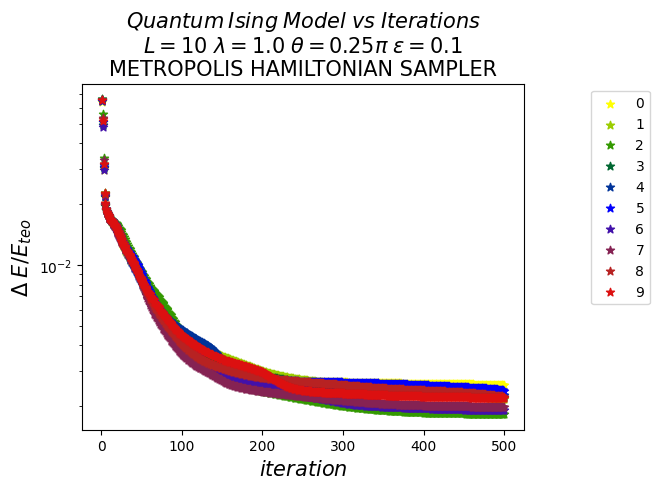

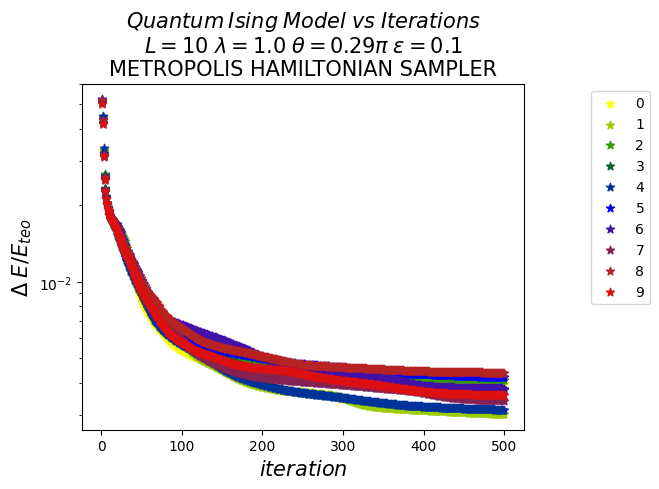

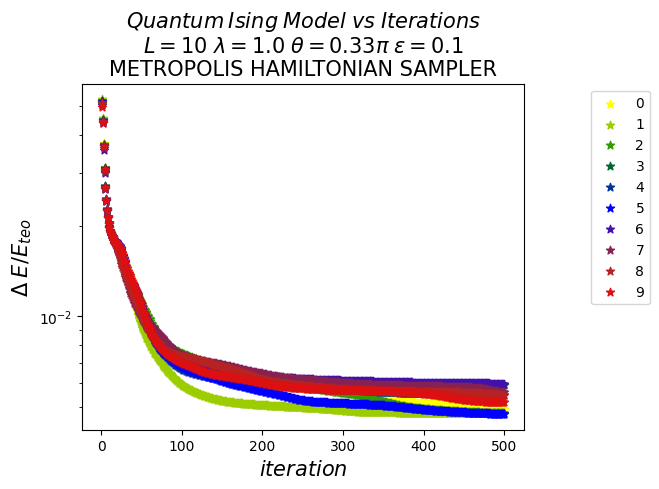

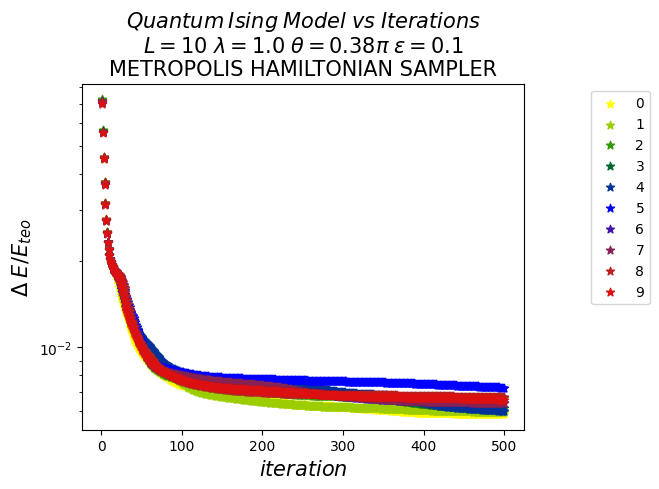

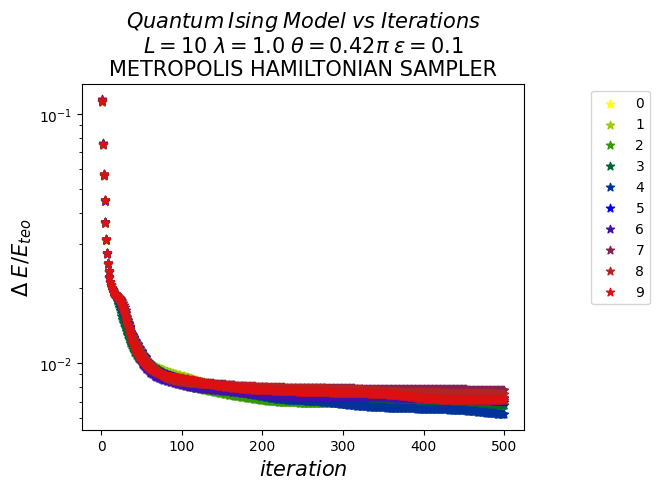

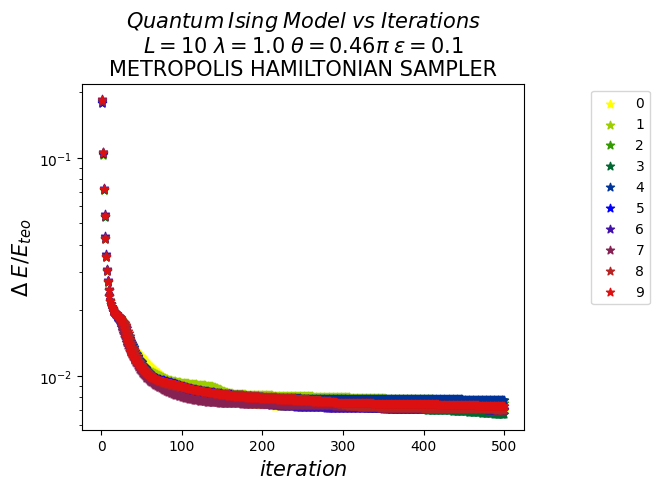

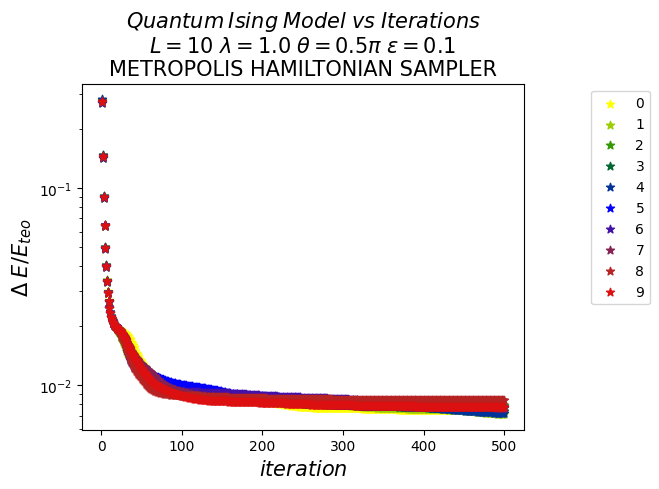

In [1574]:


print(E_all.shape)
for s in range(len(AA)):
    i=AA[s]
    fig,axis=plt.subplots(1,1,figsize=(7,5))
    plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+r"\;"+r"\theta="+str(round(i/(2*Nangle),2))+"\pi\;\epsilon="+str(round(DS*0.1,1))+"$"+"\n"+"METROPOLIS HAMILTONIAN SAMPLER",fontsize=15)
    for k in NMM[s]:
        axis.scatter(X,E_all[k][i],marker="*",color=cmap(k/NM*1.0),label=str(k))
    plt.legend(bbox_to_anchor=(1.3,1))
    #plt.xscale("log")    tr
    plt.yscale("log")
    plt.xlabel("$iteration$",fontsize=15)
    plt.ylabel(r"$\Delta\;E/E_{teo}$",fontsize=15)
    #axis.legend()
    plt.tight_layout()
    plt.savefig(MASTER_DIR+"/"+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+"DIF_LEARNING_RATES.png")

(10, 13, 500)
(10, 13, 500)


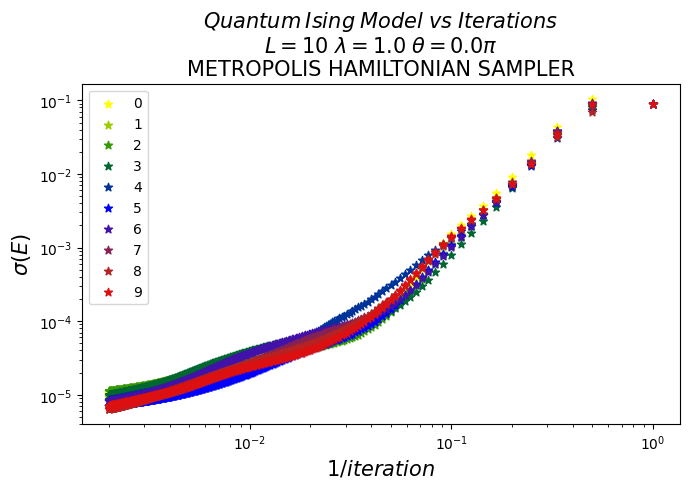

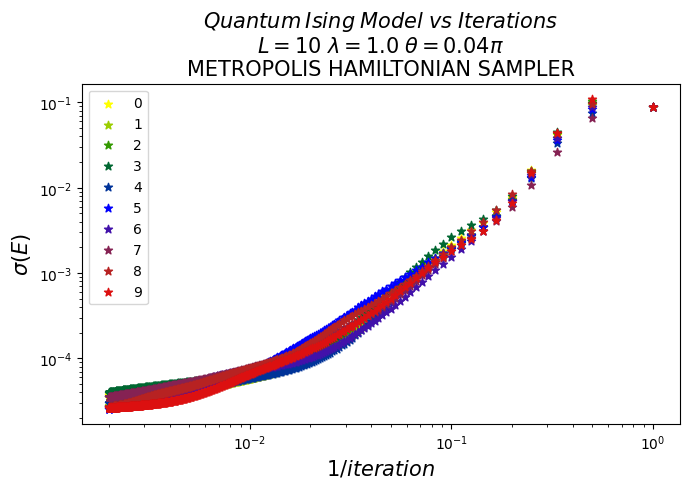

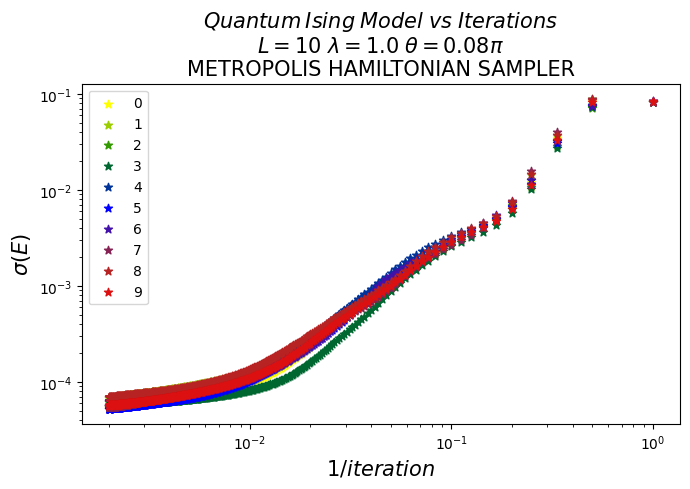

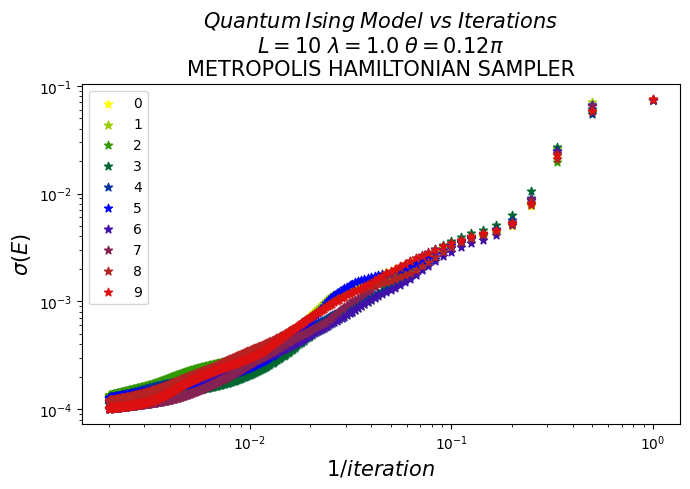

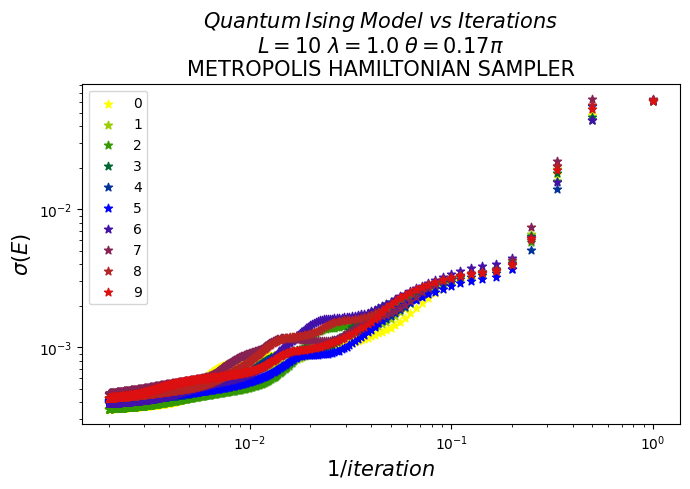

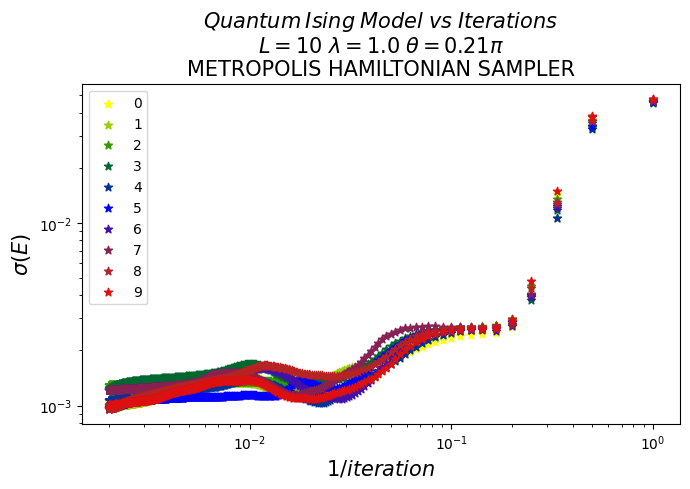

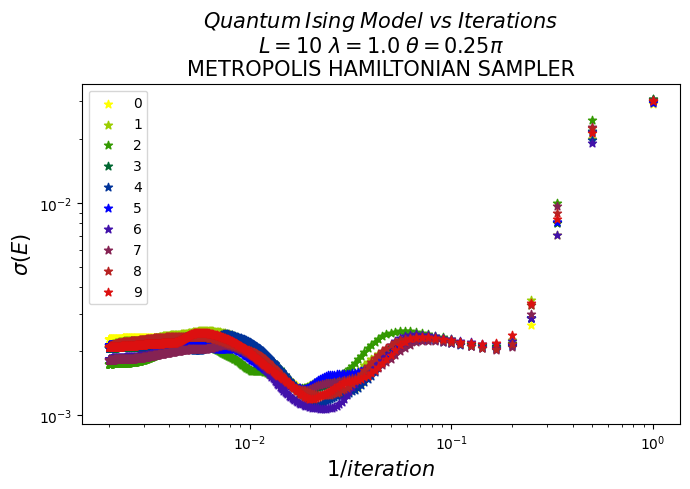

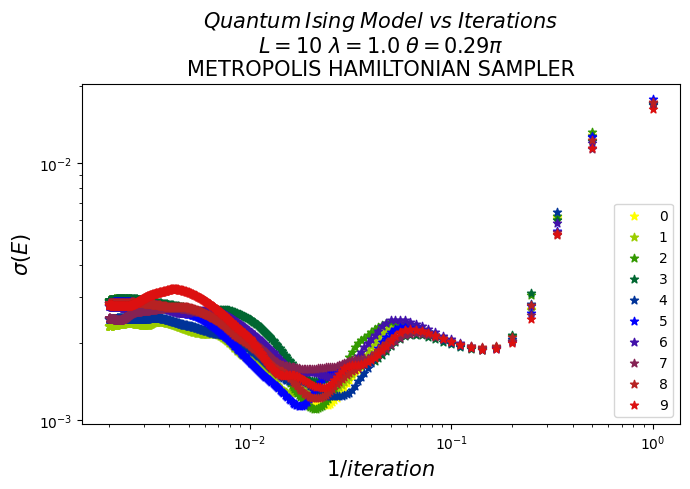

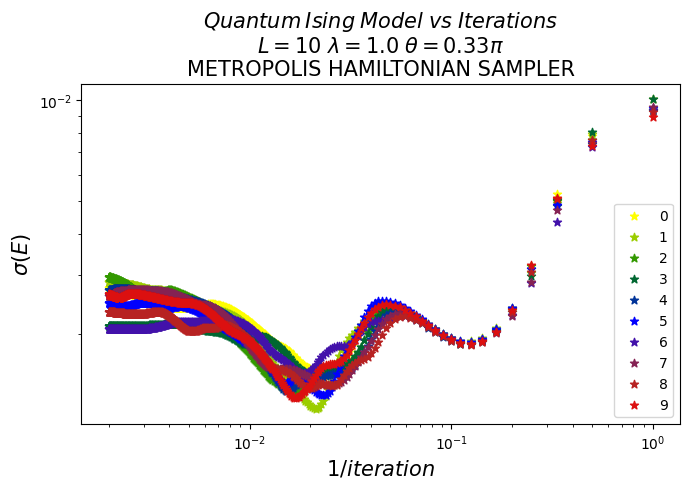

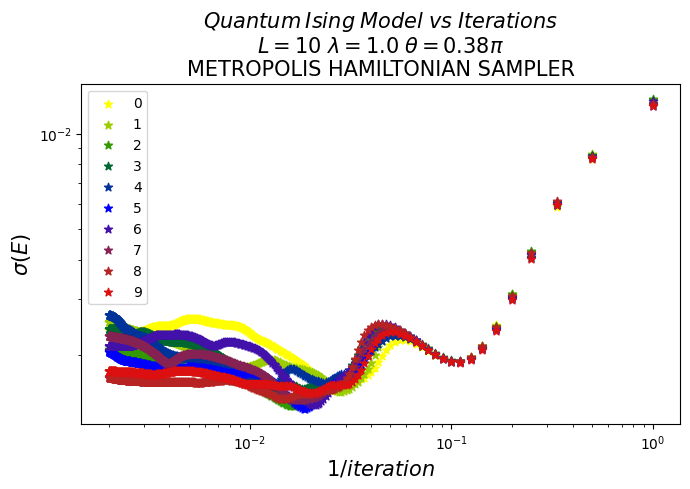

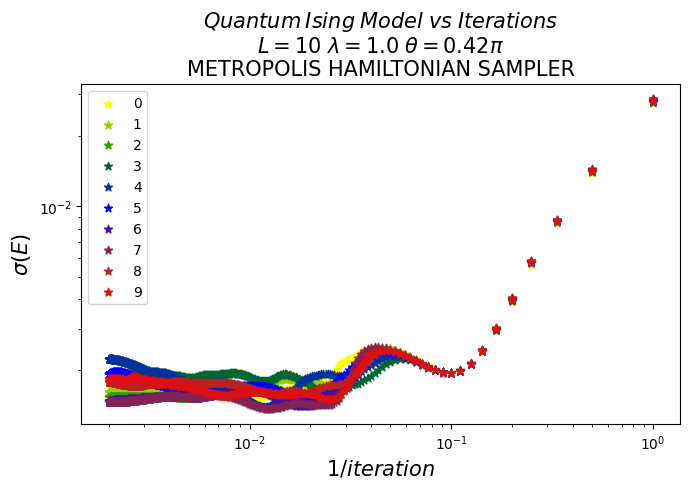

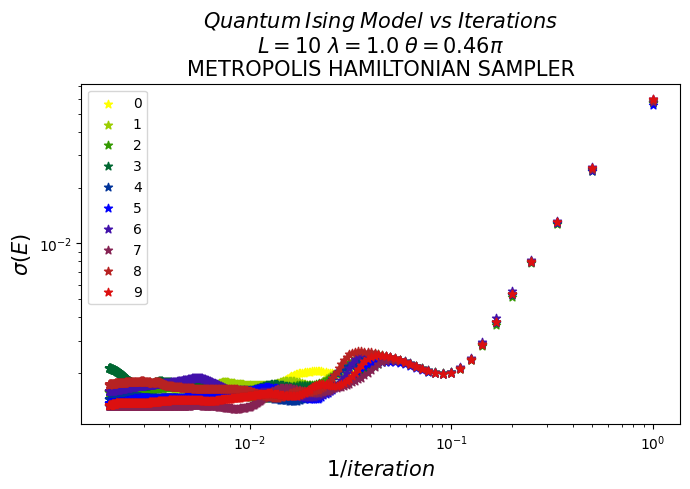

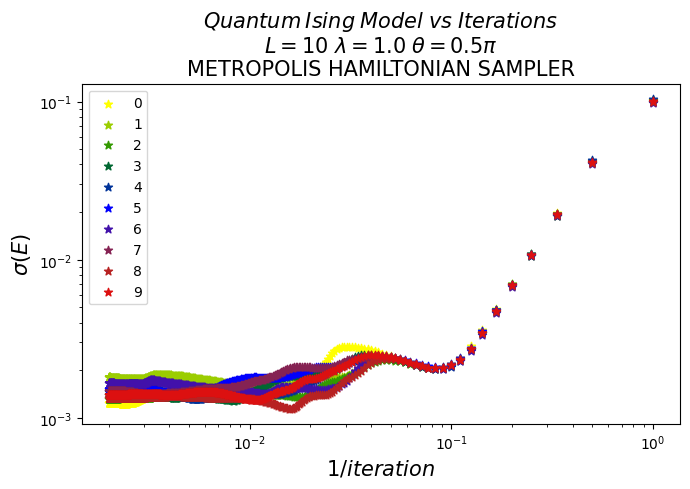

In [1575]:
print(E_all.shape)
print(dE.shape)
for s in range(len(AA)):
    i=AA[s]
    fig,axis=plt.subplots(1,1,figsize=(7,5))
    plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+r"\;"+r"\theta="+str(round(i/(2*Nangle),2))+r"\pi$"+"\n"+"METROPOLIS HAMILTONIAN SAMPLER",fontsize=15)
    for k in NMM[s]:
        #print(np.sum(dE[k][i]/L is None),k,i)
        
        aux_dE=dE[k][i]/L*1.0    
        aux_dE=aux_dE[aux_dE != np.nan]
        x_aux=X[dE[k][i]/L != np.nan]
        
        try:     
            axis.scatter(1/x_aux,aux_dE/L,marker="*",color=cmap(k/NM*1.0),label=str(k))
        except:
            print("not possible")
    plt.legend(bbox_to_anchor=(1.3,1))
    plt.xscale("log")    #tr
    plt.yscale("log")
    plt.xlabel("$1/iteration$",fontsize=15)
    plt.ylabel(r"$\sigma(E)$",fontsize=15)
    axis.legend()
    plt.tight_layout()
    plt.savefig(MASTER_DIR+"/"+"SBASIS"+str(i)+basis+"L"+str(L)+"G"+str(G)+"NS"+"DIF_LEARNING_RATES.png")

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_16720/3315862680.py:6: SyntaxWarning: invalid escape sequence '\p'
  plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+r"\;"+r"\theta="+str(round(i/(Nangle*2),2))+"\pi$"+"\n"+"METROPOLIS HAMILTONIAN SAMPLER",fontsize=15)


(10, 13, 500)
0
1
2
3
4
5
6
7
8
9
10
11
12


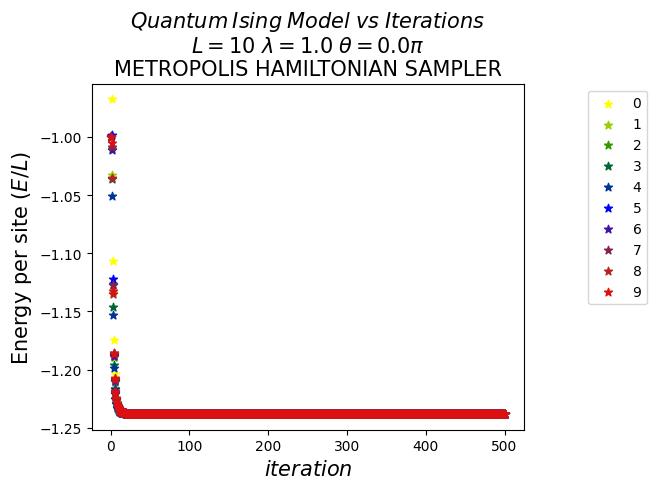

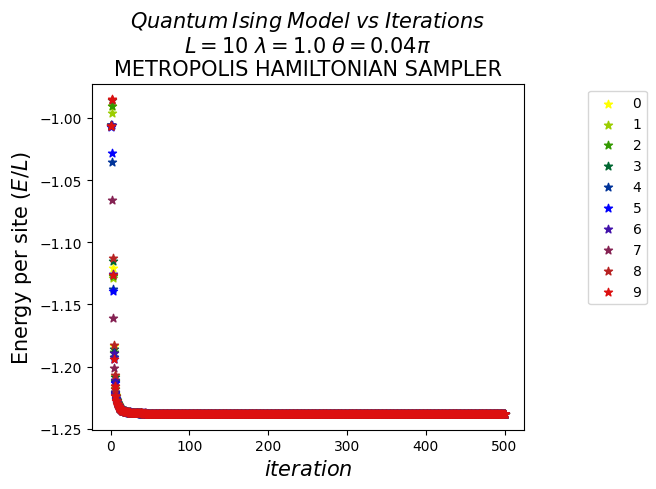

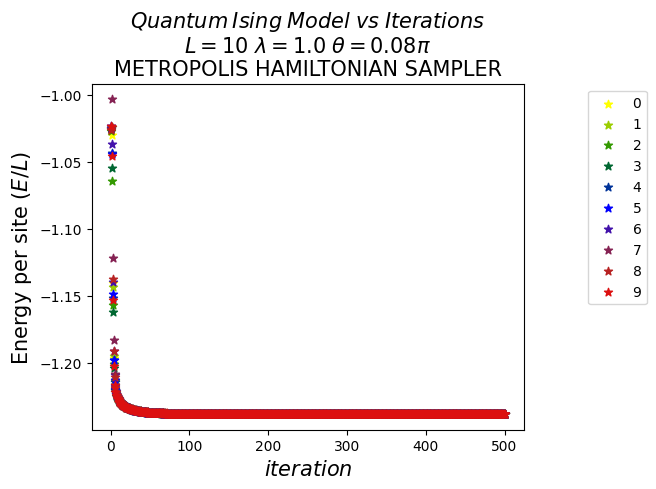

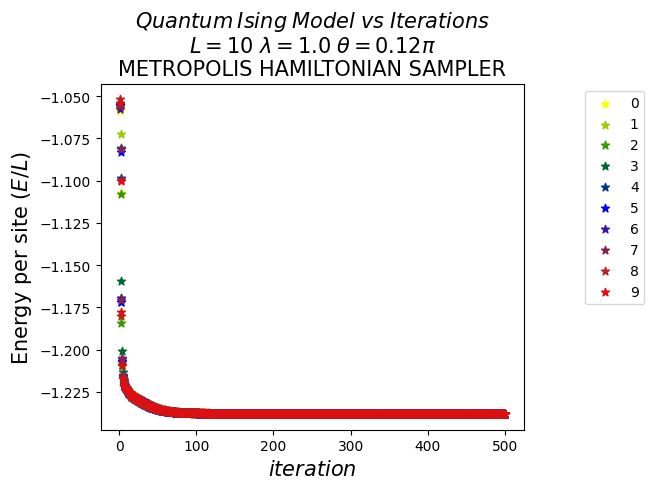

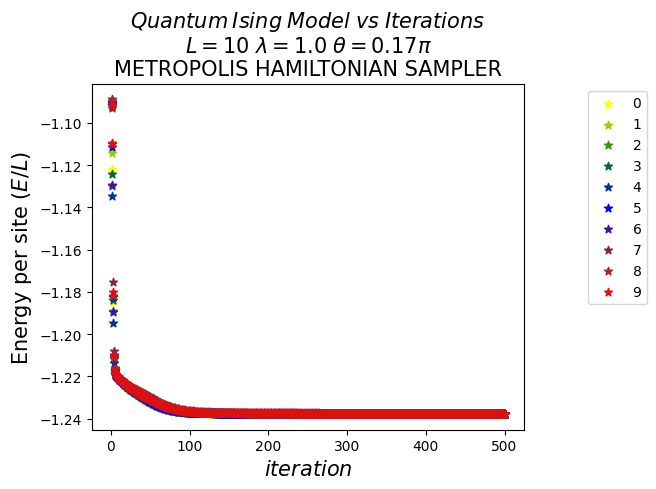

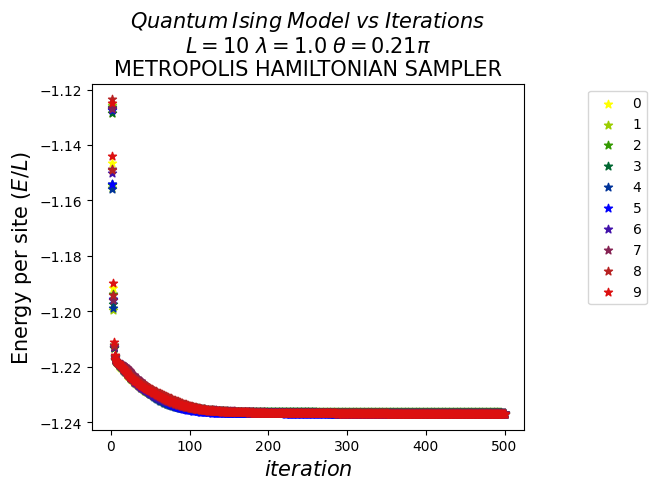

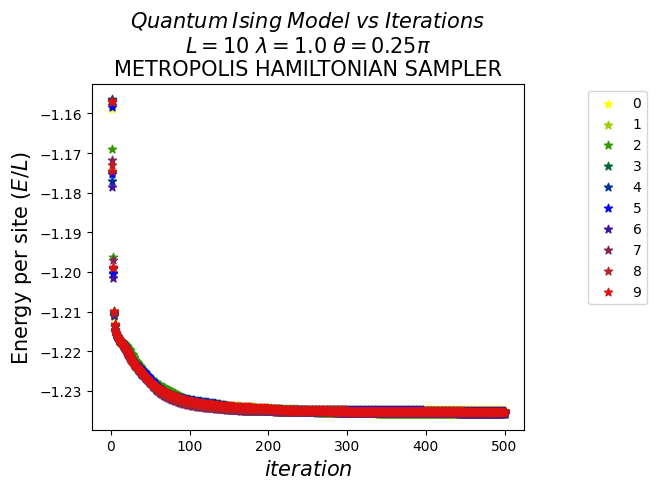

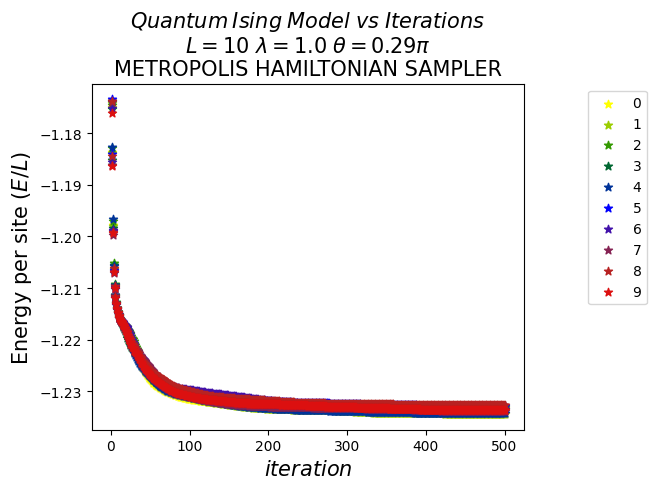

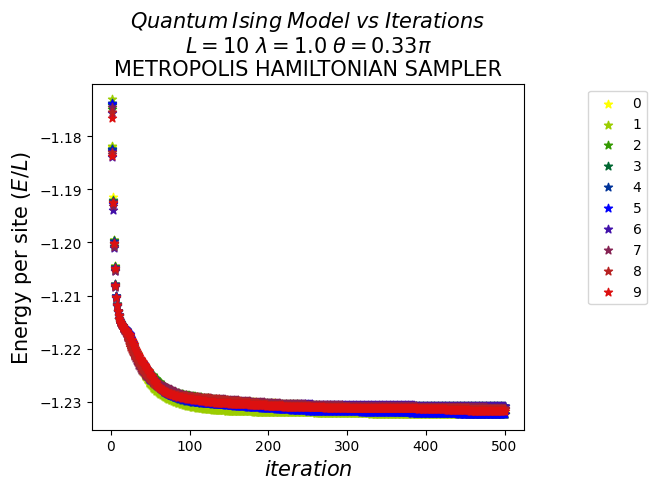

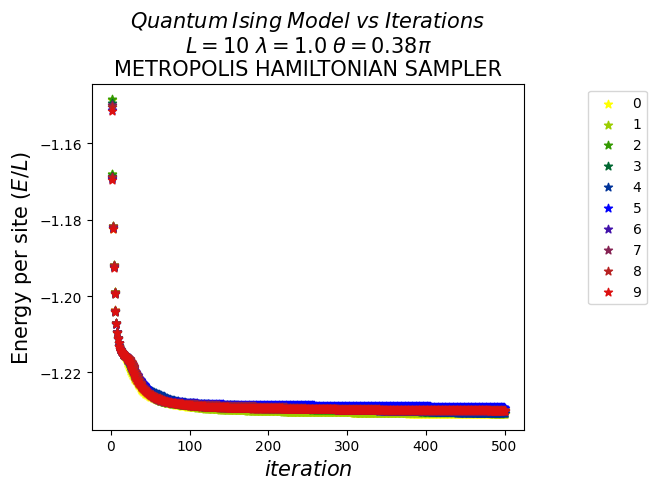

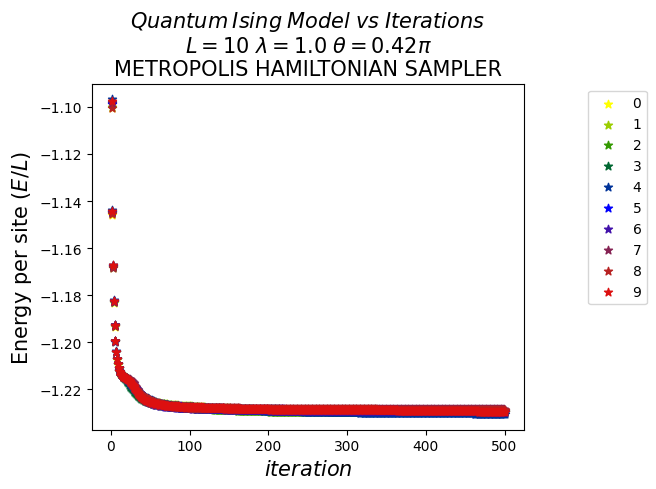

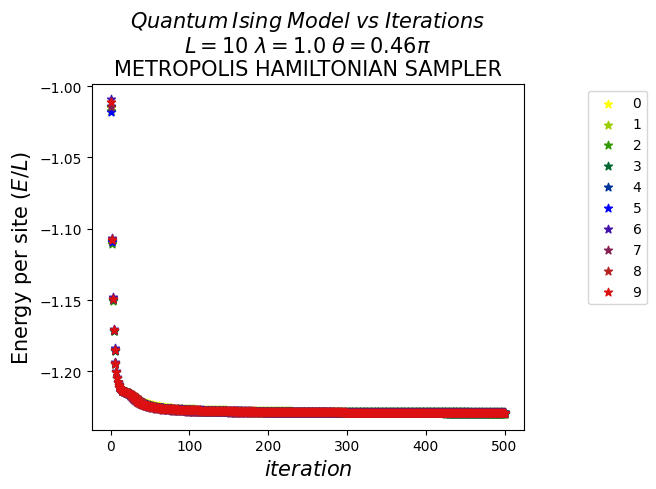

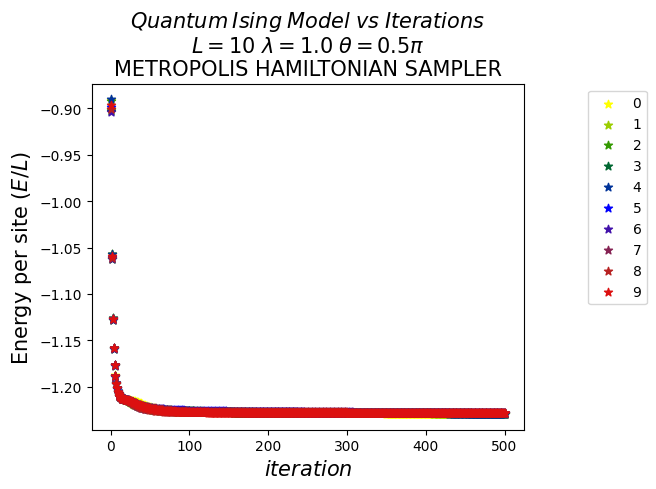

In [1576]:
print(E_all.shape)
for s in range(len(AA)):
    i=AA[s]
    print(i)
    fig,axis=plt.subplots(1,1,figsize=(7,5))
    plt.title(r"$Quantum\:Ising\;Model\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+r"\;"+r"\theta="+str(round(i/(Nangle*2),2))+"\pi$"+"\n"+"METROPOLIS HAMILTONIAN SAMPLER",fontsize=15)
    for k in NMM[s]:
        axis.scatter(X,E[k][i]/L,marker="*",color=cmap(k/NM*1.0),label=str(k))
    plt.legend(bbox_to_anchor=(1.3,1))
    #print(E[k][i])
    #plt.xscale("log")    tr
    #plt.yscale("log")
    plt.xlabel("$iteration$",fontsize=15)
    plt.ylabel(r"Energy per site $(E/L)$",fontsize=15)
    #axis.legend()
    plt.tight_layout()
    plt.savefig(MASTER_DIR+"/"+"BASIS"+str(s)+basis+"L"+str(L)+"G"+str(G)+"DIF_LEARNING_RATES.png")

In [1577]:
#Naffec=3
Naffec=len(AA)
BB=np.arange(Nangle)
BB
E=[]
E_mean_RBM=[]
dE=[]
NN=np.zeros(Nangle+1)

for i in range(Nangle+1):
    E.append(np.mean(E_all[NMM[i],i,:],axis=0))
    E_mean_RBM.append(np.mean(E_RBM[NMM[i],i,:],axis=0))
    dE.append(np.var(E_all[NMM[i],i,:],axis=0))
    NN[i]=len(NMM[i])
E=np.array(E)
E_mean_RBM=np.array(E_mean_RBM)
dE=np.array(dE)
#dE=np.mean(dE,axis=0)

In [1578]:
E_all.shape

(10, 13, 500)

In [1579]:
E.shape

(13, 500)

In [1580]:
# ENERGY
X=np.array(data_RBM[0][0]["Energy"]["iters"])+1.0


In [1581]:
print(len(X),len(E[0]))

500 500


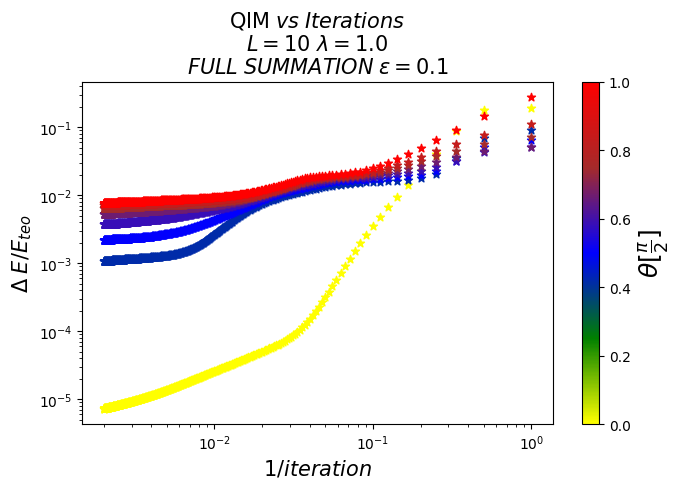

In [1582]:
fig,axis=plt.subplots(1,1,figsize=(7,5))


plt.title(basis+"$"+r"\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+"\n"+add,fontsize=15)
AA=[0,5,6,7,8,9,10,12]

for i in AA:
    axis.scatter(1/X,E[i],marker="*",color=cmap(i/Nangle*1.0))
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$1/iteration$",fontsize=15)
plt.ylabel(r"$\Delta\;E/E_{teo}$",fontsize=15)

#axis.legend()
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs an array, even an empty one is fine
cbar = plt.colorbar(sm,ax=axis,label=r'$\theta[\frac{\pi}{2}]$')
cbar.set_label(r'$\theta[\frac{\pi}{2}]$', fontsize=18)
plt.tight_layout()
plt.savefig(MASTER_DIR+"/"+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+"DIF_LEARNING_RATES"+adder+".png")

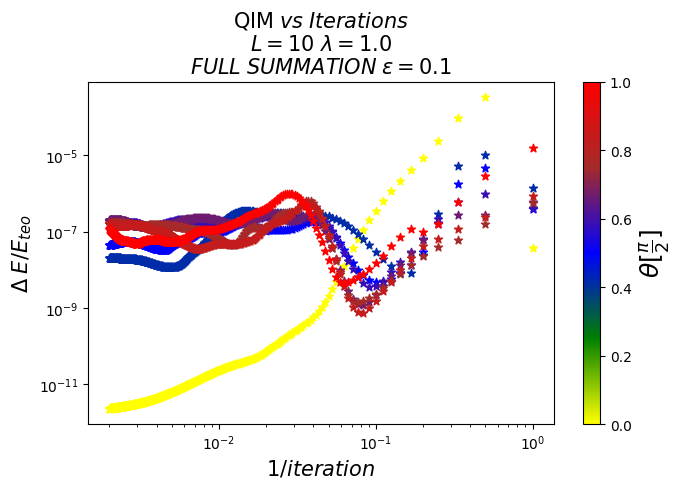

In [1583]:
fig,axis=plt.subplots(1,1,figsize=(7,5))


plt.title(basis+"$"+r"\;vs\;Iterations$"+"\n"+r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,1))+"$"+"\n"+add,fontsize=15)
AA=[0,5,6,7,8,9,10,12]

for i in AA:
    axis.scatter(1/X,dE[i],marker="*",color=cmap(i/Nangle*1.0))
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$1/iteration$",fontsize=15)
plt.ylabel(r"$\Delta\;E/E_{teo}$",fontsize=15)

#axis.legend()
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs an array, even an empty one is fine
cbar = plt.colorbar(sm,ax=axis,label=r'$\theta[\frac{\pi}{2}]$')
cbar.set_label(r'$\theta[\frac{\pi}{2}]$', fontsize=18)
plt.tight_layout()
plt.savefig(MASTER_DIR+"/"+"BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+"DIF_LEARNING_RATES"+adder+".png")

In [1584]:
#RELATIVE ERROR LAST ITERATION

In [1585]:
Y=np.array(E)
RBM_E=np.array(E_mean_RBM)
T_CORR=1
N_SAMPLES=1
X_INDICES=[NR-1-T_CORR*kk for kk in range(N_SAMPLES)]
YY=[]
EY=[]
Y_err=[]
for ii in range(Nangle+1):
    YY.append(np.mean(Y[ii,X_INDICES]))
    EY.append(np.mean(RBM_E[ii,X_INDICES]))
    Y_err.append(dE[ii,NR-1])
Y_err=np.array(Y_err)

In [1586]:
PSI_TEO=np.array(PSI_TEO)
IPR_TEO=[0.0 for ii in range(Nangle+1)] 
IPR_RBM=[0.0 for ii in range(Nangle+1)]
Fidelity=[0.0 for ii in range(Nangle+1)]
Fidelity_EXC=[0.0 for ii in range(Nangle+1)]

wrong_mean_sign=[0.0 for ii in range(Nangle+1)]
wrong_mean_amp=[0.0 for ii in range(Nangle+1)]
N_wrong_amp=[0.0 for ii in range(Nangle+1)]

wrong_mean_sign_RBM=[0.0 for ii in range(Nangle+1)]
wrong_mean_amp_RBM=[0.0 for ii in range(Nangle+1)]

mean_sign_pplus=[0.0 for ii in range(Nangle+1)]
mean_sign_pminus=[0.0 for ii in range(Nangle+1)]

mean_sign_pplus_RBM=[0.0 for ii in range(Nangle+1)]
mean_sign_pminus_RBM=[0.0 for ii in range(Nangle+1)]


N_M=[]
for aa in range(Nangle+1-Naffec):
    N_M.append([i for i in range(NM)])
for bb in range(Naffec):
    N_M.append(NMM[bb])
    
for phi in range(Nangle+1): 
    ############
    hi=nk.hilbert.Spin(s=1/2,N=L)
    if phi==Nangle+1:
        hk=nk.hilbert.Spin(s=1/2,N=L,constraint=class_WF.ParityConstraint())
        if basis=="CIM":
            hk=hi
        
    else:
        hk=hi
    #############    
    WF=PSI_TEO[phi]
    WF_EXC=EXC_PSI_TEO[phi]
    IPR_TEO[phi]=np.sum((WF**2) * np.conjugate(WF**2))
    aux_param=[]
    fidelity_aux=[]
    fidelity_exc_aux=[]
    wrong_mean_sign_aux=[]
    wrong_mean_amp_aux=[]
    wrong_mean_sign_aux_RBM=[]
    wrong_mean_amp_aux_RBM=[]
    N_wrong_amp_aux=[]
    mean_sign_pminus_aux=[]
    mean_sign_pplus_aux=[]
    mean_sign_pminus_aux_RBM=[]
    mean_sign_pplus_aux_RBM=[]
    for kk in N_M[i]:
        param_RBM=data[kk][phi]
        P=GET_PROB_RBM(hk,param_RBM,NSPCA)
        #print(WF@P)
        P=P/(P[0]/np.linalg.norm(P[0]))

        WF[np.abs(WF)<10**(-15)]=0.0
        P[np.abs(P)<10**(-15)]=0.0
        wrong_sign=np.sign(WF)!=np.sign(np.real(P))
        
        #print(P[wrong_sign],WF[wrong_sign])
        N_wrong_amp_aux.append(np.sum(wrong_sign)*1.0)
        print(N_wrong_amp_aux)
        states=hi.all_states()[wrong_sign]
        num_states=hi.states_to_numbers(states)
        
        print(hi.all_states()[wrong_sign])
        #print(states,num_states)
        print(P[wrong_sign],WF[wrong_sign])
        wrong_mean_sign_aux.append(np.abs(np.sum(WF[wrong_sign]*np.conjugate(WF[wrong_sign])*np.sign(np.real(WF[wrong_sign])))))
        wrong_mean_amp_aux.append(np.abs(np.sum(WF[wrong_sign]*np.conjugate(WF[wrong_sign]))))

        wrong_mean_sign_aux_RBM.append(np.abs(np.sum(P[wrong_sign]*np.conjugate(P[wrong_sign])*np.sign(np.real(P[wrong_sign])))))
        wrong_mean_amp_aux_RBM.append(np.abs(np.sum(P[wrong_sign]*np.conjugate(P[wrong_sign]))))
        
        #print(P@np.conjugate(P),WF@np.conjugate(WF),WF_EXC@np.conjugate(WF_EXC),WF@WF_EXC)
        fidelity_aux.append(np.linalg.norm(WF@P))
        fidelity_exc_aux.append(np.linalg.norm(WF_EXC@P))
        aux_param.append(np.sum(np.absolute(P)**4))

        mean_sign_pminus_aux.append(np.abs(WF)@Pminus@WF)
        mean_sign_pplus_aux.append(np.abs(WF)@Pplus@WF)

        mean_sign_pminus_aux_RBM.append(np.abs(P)@Pminus@P)
        mean_sign_pplus_aux_RBM.append(np.abs(P)@Pplus@P)
        
    aux_param=np.array(aux_param)
    wrong_mean_sign_aux=np.array(wrong_mean_sign_aux)
    wrong_mean_amp_aux=np.array(wrong_mean_amp_aux)
    
    wrong_mean_sign_aux_RBM=np.array(wrong_mean_sign_aux_RBM)
    wrong_mean_amp_aux_RBM=np.array(wrong_mean_amp_aux_RBM)
    
    N_wrong_amp_aux=np.array(N_wrong_amp_aux) 
    
    fidelity_aux=np.array(fidelity_aux)
    fidelity_exc_aux=np.array(fidelity_exc_aux)

    mean_sign_pminus_aux=np.array(mean_sign_pminus_aux)
    mean_sign_pplus_aux=np.array(mean_sign_pplus_aux)
    mean_sign_pminus_aux_RBM=np.array(mean_sign_pminus_aux_RBM)
    mean_sign_pplus_aux_RBM=np.array(mean_sign_pplus_aux_RBM)
    
    wrong_mean_sign[phi]=np.mean(wrong_mean_sign_aux)
    wrong_mean_amp[phi]=np.mean(wrong_mean_amp_aux)

    wrong_mean_sign_RBM[phi]=np.mean(wrong_mean_sign_aux_RBM)
    wrong_mean_amp_RBM[phi]=np.mean(wrong_mean_amp_aux_RBM)
    Fidelity[phi]=np.mean(fidelity_aux)
    Fidelity_EXC[phi]=np.mean(fidelity_exc_aux)

    mean_sign_pplus[phi]=np.mean(mean_sign_pplus_aux)
    mean_sign_pminus[phi]=np.mean(mean_sign_pminus_aux)
    mean_sign_pplus_RBM[phi]=np.mean(mean_sign_pplus_aux_RBM)
    mean_sign_pminus_RBM[phi]=np.mean(mean_sign_pminus_aux_RBM)
    
    print(wrong_mean_amp_aux,N_wrong_amp_aux)
    N_wrong_amp[phi]=np.mean((wrong_mean_amp_aux/N_wrong_amp_aux))
    aux_param_2=[]
    for jjs in aux_param:
        if not np.isnan(jjs):
            aux_param_2.append(jjs)
    aux_param_2=np.array(aux_param_2)
    #print(aux_param_2)
    IPR_RBM[phi]=np.mean(aux_param_2)
  

[0.0]
[]
[] []
[0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0]
[]
[] []
[0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0]


/tmp/ipykernel_16720/3188005748.py:120: RuntimeWarning: invalid value encountered in divide
  N_wrong_amp[phi]=np.mean((wrong_mean_amp_aux/N_wrong_amp_aux))


[]
[] []
[0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0]
[]
[] []
[0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0]
[]
[] []
[0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[]
[] []
[0.0, 0.

In [1587]:
#ANGLES
ANGLES=np.array(range(Nangle+1))
Y0=None
for kk in range(Nangle+1):
    if N_pos[kk]<eps:
        continue
    else:
        Y0=kk
        break

In [1588]:
norm_1 = mcolors.Normalize(vmin=np.abs(0), vmax=1)
colors_1 = [(0.0, 'white'),(1.0, "black")]
cmap_1 = LinearSegmentedColormap.from_list('gray_scale', colors_1)


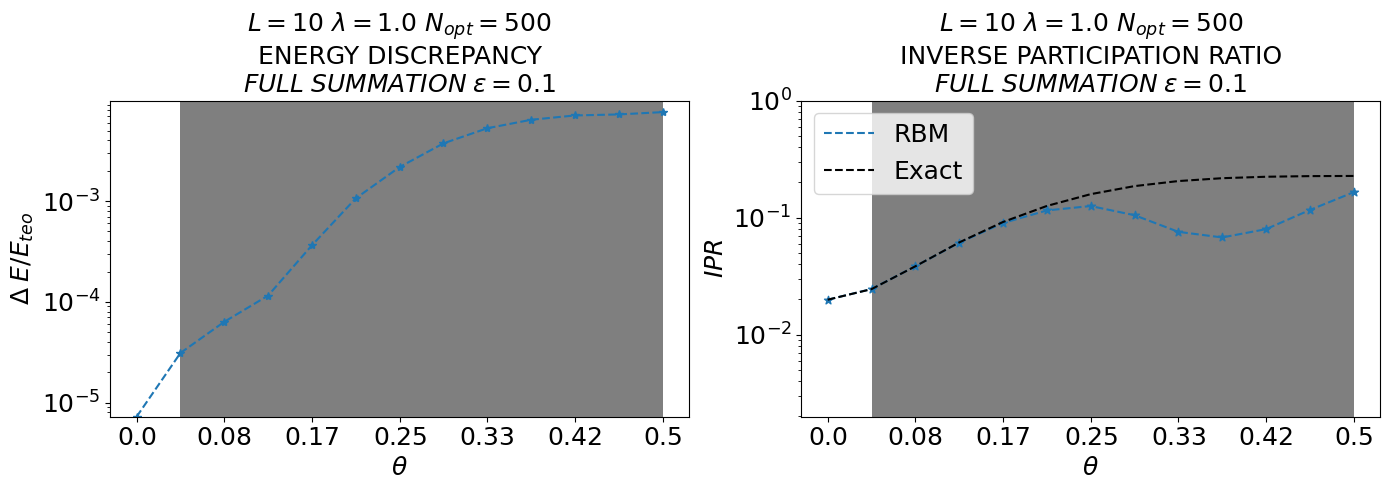

In [1589]:
N_label_freq=2
fsize=18
xticks=np.arange(0,Nangle+1,N_label_freq)
x_labels=[r"$\frac{"+str(i)+r"\pi}{"+str(2*Nangle)+"}$" for i in xticks]
x_labels=[r"$"+str(round(i/(2*Nangle),2))+"$" for i in xticks]
YYY=YY

fig,axis=plt.subplots(1,2,figsize=(14,5))
axis[0].set_title(r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,2))+"$"+" $N_{opt}="+str(NR)+"$"+"\n"+"ENERGY DISCREPANCY"+"\n"+add,fontsize=fsize)
axis[0].set_xticks(xticks,x_labels,fontsize=fsize)
axis[1].set_xticks(xticks,x_labels,fontsize=fsize)
axis[0].tick_params(axis='y', labelsize=fsize)
axis[1].tick_params(axis='y', labelsize=fsize)
axis[1].set_title(r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,2))+"$"+" $N_{opt}="+str(NR)+"$\n"+"INVERSE PARTICIPATION RATIO"+"\n"+add,fontsize=fsize)

axis[0].errorbar(ANGLES,YYY,yerr=np.sqrt(Y_err)/NN[i],marker="*",linestyle="dashed")
#if Y0!=None:
#    axis[0].fill_between(ANGLES[Y0:Nangle],np.min(YYY)/1.3,np.max(YYY)*1.3,alpha=.3)
for i in range(Nangle+1):
    axis[0].fill_between(ANGLES[i:i+2],np.min(YYY)/1.3,np.max(YYY)*1.5,color=cmap_1(N_pos[i]*1.0/max(N_pos)),alpha=.5,edgecolor=None)
    axis[1].fill_between(ANGLES[i:i+2],np.min(YYY)/1000,1.0,color=cmap_1(N_pos[i]*1.0/max(N_pos)),alpha=.5,edgecolor=None)

axis[0].set_ylim([np.min(YYY)/1.0,np.max(YYY)*1.3])
axis[1].set_ylim([np.min(IPR_TEO)/10.0,1.0])

axis[0].set_yscale("log")
axis[0].set_xlabel(r"$\theta$",fontsize=fsize)
axis[0].set_ylabel(r"$\Delta\;E/E_{teo}$",fontsize=fsize)

axis[1].scatter(ANGLES,IPR_RBM,marker="*")
axis[1].plot(ANGLES,IPR_RBM,linestyle="dashed",label="RBM")
axis[1].plot(ANGLES,IPR_TEO,color="black",linestyle="dashed",label="Exact")

axis[1].set_xlabel(r"$\theta$",fontsize=fsize)
axis[1].set_ylabel(r"$IPR$",fontsize=fsize)


#axis[0].set_xlim([0,ANGLES[Nangle-2]])
#axis[1].set_xlim([0,ANGLES[Nangle-2]])

#if Y0!=None:
#    axis[1].fill_between(ANGLES[Y0:Nangle],np.min(IPR_TEO)/20.0,np.max(IPR_TEO)*100.0,alpha=.3)
plt.legend(fontsize=fsize)
#axis[1].set_ylim([np.min(IPR_TEO)/10.0,np.max(IPR_TEO)*2.0])
axis[1].set_yscale("log")

sm = mpl.cm.ScalarMappable(cmap=cmap_1, norm=norm_1)
sm.set_array([])  # ScalarMappable needs an array, even an empty one is fine
#cbar = plt.colorbar(sm,ax=axis,label=r'$N_{+}$')
#cbar.set_label(r'$N_{+}$', fontsize=18)

plt.tight_layout()
plt.savefig("THETA_BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+"IPR_ED"+adder+".jpg")

In [1590]:
############## GRAPH FOR THE SIGN

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_16720/277115898.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.errorbar(ANGLES,YYY,yerr=np.sqrt(Y_err)/NN[i],marker="*",color="green",linestyle="dashed",label="$\Delta E/E_{theo},\epsilon="+str(DS*0.01)+"$")


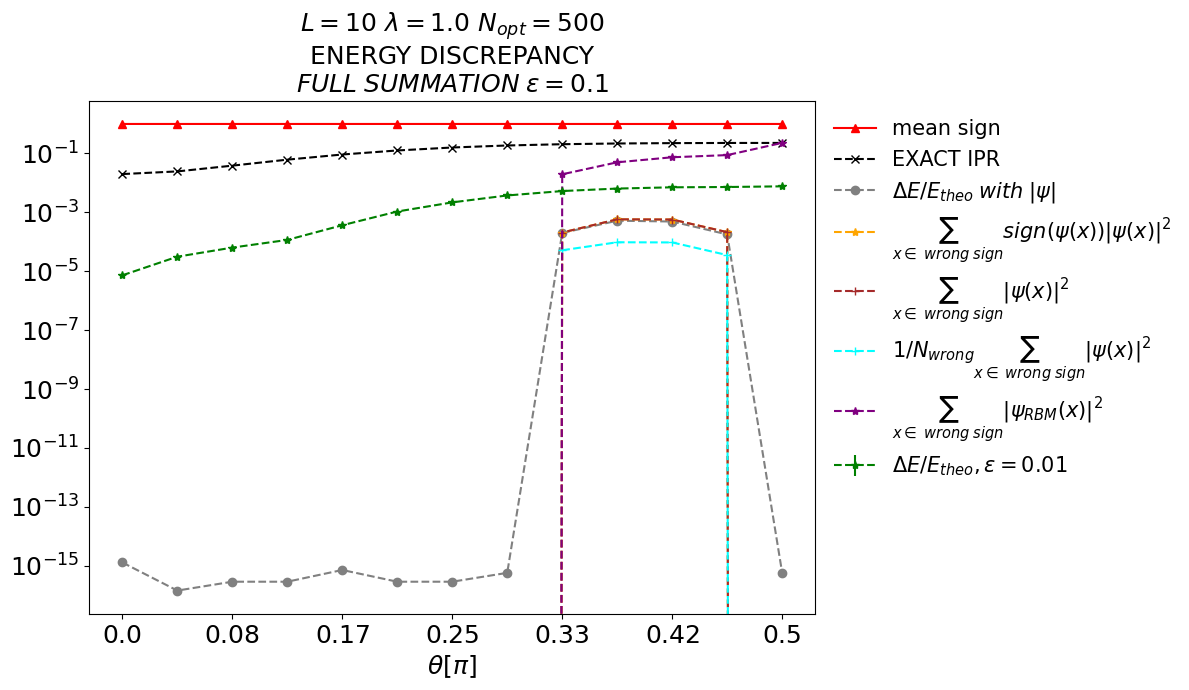

In [1591]:
plt.figure(figsize=(12,7))
plt.title(r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,2))+"$"+" $N_{opt}="+str(NR)+"$"+"\n"+"ENERGY DISCREPANCY"+"\n"+add,fontsize=fsize)
plt.xticks(xticks,x_labels,fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel(r"$\theta[\pi]$",fontsize=fsize)
#plt.ylabel(r"$\Delta\;E/E_{teo}$",fontsize=fsize)
plt.yscale("log")
plt.errorbar(ANGLES,YYY,yerr=np.sqrt(Y_err)/NN[i],marker="*",color="green",linestyle="dashed",label="$\Delta E/E_{theo},\epsilon="+str(DS*0.01)+"$")
plt.plot(ANGLES,mean_sign,marker='^', linestyle='-',label="mean sign",color="red")
plt.plot(ANGLES,IPR_TEO,color="black",marker="x",linestyle="dashed",label="EXACT IPR")

plt.plot(ANGLES,E_wsgn,color="gray",marker="o",linestyle="dashed",label=r"$\Delta E/E_{theo} \;with\;|\psi|$")

#plt.plot(ANGLES,np.array(Fidelity)**2,color="magenta",marker="*",linestyle="dashed",label=r"$\langle \psi_{teo} | \psi_{RBM} \rangle$")
#plt.plot(ANGLES,Fidelity_EXC,color="blue",marker="*",linestyle="dashed",label=r"$\langle \psi_{teo,exc} | \psi_{RBM} \rangle$")

plt.plot(ANGLES,np.real(wrong_mean_sign),color="orange",marker="*",linestyle="dashed",label=r"$\sum_{x \in \;wrong \;sign} sign(\psi(x))|\psi(x)|^2$")
plt.plot(ANGLES,np.real(wrong_mean_amp),color="brown",marker="+",linestyle="dashed",label=r"$\sum_{x \in \;wrong \;sign} |\psi(x)|^2$")

plt.plot(ANGLES,np.real(np.array(N_wrong_amp)),color="cyan",marker="+",linestyle="dashed",label=r"$1/N_{wrong}\sum_{x \in \;wrong \;sign} |\psi(x)|^2$")

plt.plot(ANGLES,np.real(wrong_mean_sign_RBM),color="purple",marker="*",linestyle="dashed",label=r"$\sum_{x \in \;wrong \;sign} |\psi_{RBM}(x)|^2$")

#plt.plot(ANGLES,np.real(wrong_mean_amp_RBM),color="pink",marker="+",linestyle="dashed",label=r"$\sum_{x \in \;wrong \;sign} |\psi_{RBM}(x)|^2$")

#plt.plot(ANGLES,IPR_RBM,color="orange",marker="x",linestyle="dashed",label="RBM IPR")




plt.legend(fontsize=15,framealpha=0.0,bbox_to_anchor=(1.0,1.0))
plt.tight_layout()
plt.savefig("THETA_BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+"IPR_ED"+adder+"comparison.png")


In [1592]:
mean_sign

[1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004,
 0.9999999999999994,
 0.9999999999999991,
 0.9999999999999999,
 1.0000000000000002,
 0.9999999999999999,
 0.9995881610765184,
 0.9988445338743206,
 0.9988603711908544,
 0.9995758130714824,
 0.9999999999999996]

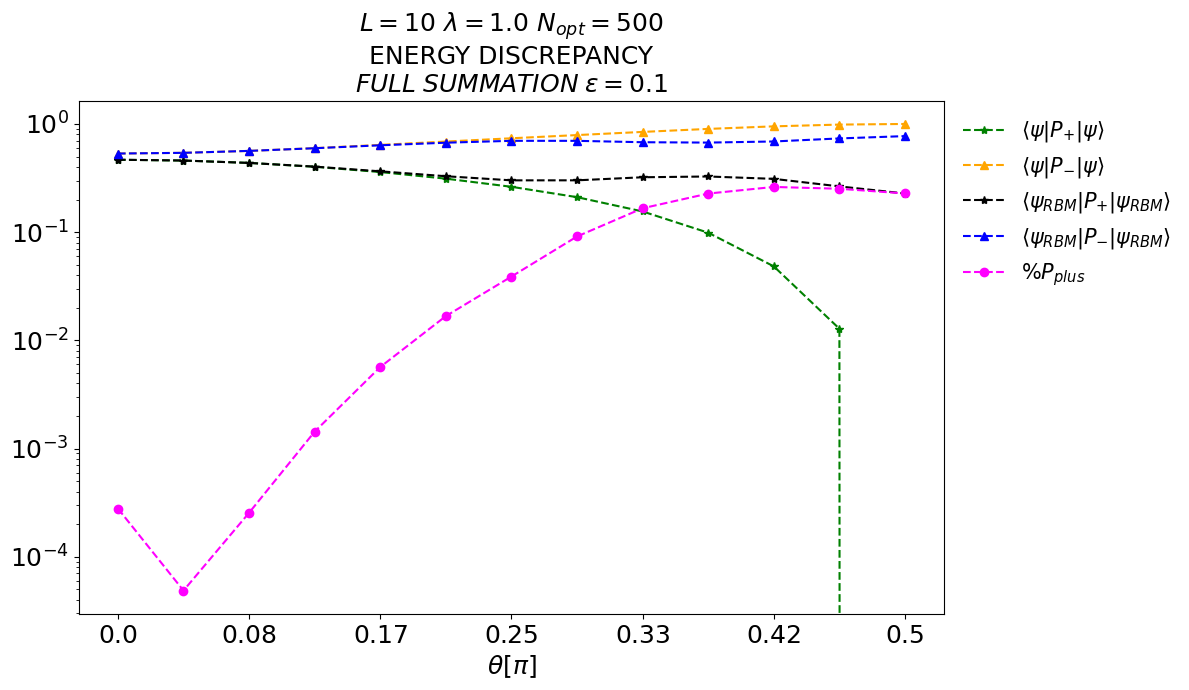

In [1593]:
plt.figure(figsize=(12,7))
plt.title(r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,2))+"$"+" $N_{opt}="+str(NR)+"$"+"\n"+"ENERGY DISCREPANCY"+"\n"+add,fontsize=fsize)
plt.xticks(xticks,x_labels,fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel(r"$\theta[\pi]$",fontsize=fsize)
#plt.ylabel(r"$\Delta\;E/E_{teo}$",fontsize=fsize)
plt.yscale("log")

plt.plot(ANGLES,np.real(mean_sign_pminus),color="green",marker="*",linestyle="dashed",label=r"$\langle \psi |P_{+}| \psi\rangle$")
plt.plot(ANGLES,np.real(mean_sign_pplus),color="orange",marker="^",linestyle="dashed",label=r"$ \langle \psi |P_{-}| \psi \rangle$")

plt.plot(ANGLES,np.real(mean_sign_pminus_RBM),color="black",marker="*",linestyle="dashed",label=r"$\langle \psi_{RBM} |P_{+}| \psi_{RBM}\rangle$")
plt.plot(ANGLES,np.real(mean_sign_pplus_RBM),color="blue",marker="^",linestyle="dashed",label=r"$ \langle \psi_{RBM} |P_{-}| \psi_{RBM} \rangle$")

plt.plot(ANGLES,np.abs(np.array(mean_sign_pplus_RBM)-np.array(mean_sign_pplus)),color="magenta",marker="o",linestyle="dashed",label=r"$ \% P_{plus}$")


plt.legend(fontsize=15,framealpha=0.0,bbox_to_anchor=(1.0,1.0))
plt.tight_layout()
plt.savefig("THETA_BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+"IPR_ED"+adder+"comparison.png")



In [1594]:
mean_sign_pminus

[0.4669134834981034,
 0.4590760925121006,
 0.43652500171060316,
 0.40199046174444797,
 0.3593213265514276,
 0.31217112041405926,
 0.2625636984092576,
 0.21054087265741792,
 0.15529332006922508,
 0.09881126836246631,
 0.04825489836416865,
 0.012796985841670707,
 0.0]

<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_16720/32407427.py:12: SyntaxWarning: invalid escape sequence '\D'
  axis[0].errorbar(ANGLES,YYY,yerr=np.sqrt(Y_err)/NN[i],marker="*",color="green",linestyle="dashed",label="$\Delta E/E_{teo},\epsilon="+str(DS*0.01)+"$")


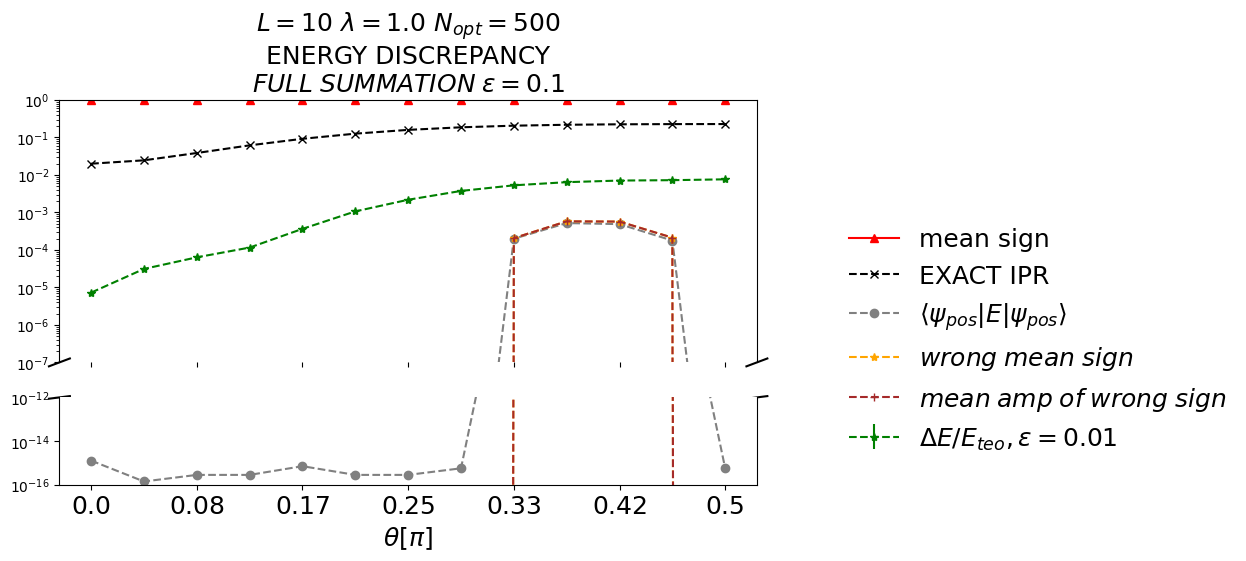

In [1595]:
# Hide the spines between axes
fig,axis=plt.subplots(2,1,figsize=(9,5),sharex=True, gridspec_kw={'height_ratios': [3, 1]})
axis[0].set_title(r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,2))+"$"+" $N_{opt}="+str(NR)+"$"+"\n"+"ENERGY DISCREPANCY"+"\n"+add,fontsize=fsize)

axis[0].set_ylim([10**(-7),1])
axis[1].set_ylim([10**(-16),10**(-12)])
plt.xlabel(r"$\theta[\pi]$",fontsize=fsize)

axis[0].set_yscale("log")
axis[1].set_yscale("log")
axis[1].set_xticks(xticks,x_labels,fontsize=fsize)
axis[0].errorbar(ANGLES,YYY,yerr=np.sqrt(Y_err)/NN[i],marker="*",color="green",linestyle="dashed",label="$\Delta E/E_{teo},\epsilon="+str(DS*0.01)+"$")
axis[0].plot(ANGLES,mean_sign,marker='^', linestyle='-',label="mean sign",color="red")
axis[0].plot(ANGLES,IPR_TEO,color="black",marker="x",linestyle="dashed",label="EXACT IPR")

axis[0].plot(ANGLES,E_wsgn,color="gray",marker="o",linestyle="dashed",label=r"$\langle \psi_{pos} |E | \psi_{pos} \rangle$")

#plt.plot(ANGLES,Fidelity,color="magenta",marker="*",linestyle="dashed",label=r"$\langle \psi_{teo} | \psi_{RBM} \rangle$")
#plt.plot(ANGLES,Fidelity_EXC,color="blue",marker="*",linestyle="dashed",label=r"$\langle \psi_{teo,exc} | \psi_{RBM} \rangle$")
axis[0].plot(ANGLES,np.real(wrong_mean_sign),color="orange",marker="*",linestyle="dashed",label=r"$wrong\;mean\;sign\;$")
axis[0].plot(ANGLES,np.real(wrong_mean_amp),color="brown",marker="+",linestyle="dashed",label=r"$mean\;amp\;of\;wrong\;sign$")

axis[1].plot(ANGLES,np.real(wrong_mean_sign),color="orange",marker="*",linestyle="dashed",label=r"$wrong\;mean\;sign\;$")
axis[1].plot(ANGLES,np.real(wrong_mean_amp),color="brown",marker="+",linestyle="dashed",label=r"$mean\;amp\;of\;wrong\;sign$")
axis[1].plot(ANGLES,E_wsgn,color="gray",marker="o",linestyle="dashed",label=r"$\langle \psi_{pos} |E | \psi_{pos} \rangle$")

axis[0].legend(fontsize=fsize,framealpha=0.0,bbox_to_anchor=(1.1,0.6))

axis[0].spines['bottom'].set_visible(False)
axis[1].spines['top'].set_visible(False)
axis[0].tick_params(labeltop=False)  # don't put tick labels at the top
axis[1].xaxis.tick_bottom()

# Add diagonal lines to indicate the break
d = .015  # size of diagonal lines in axes coordinates
kwargs = dict(transform=axis[0].transAxes, color='k', clip_on=False)
axis[1].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axis[1].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axis[1].transAxes)  # switch to the bottom axes
axis[0].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left
axis[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right

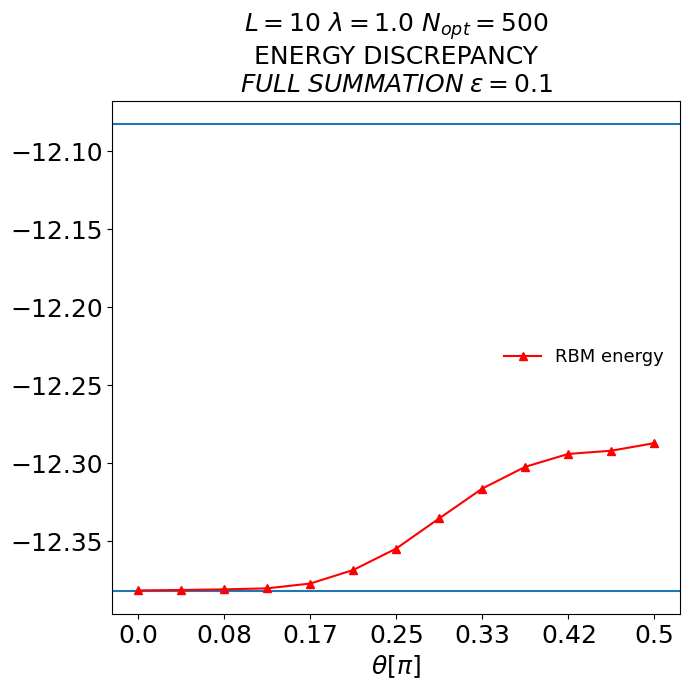

In [1596]:
plt.figure(figsize=(7,7))
plt.title(r"$L="+str(L)+"$ $" r"\lambda="+str(round(G*DG,2))+"$"+" $N_{opt}="+str(NR)+"$"+"\n"+"ENERGY DISCREPANCY"+"\n"+add,fontsize=fsize)
plt.xticks(xticks,x_labels,fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel(r"$\theta[\pi]$",fontsize=fsize)
#plt.ylabel(r"$\Delta\;E/E_{teo}$",fontsize=fsize)
plt.axhline(y=eig_vals_other[0])
plt.axhline(y=eig_vals_other[1])
plt.plot(ANGLES,EY,marker='^', linestyle='-',label="RBM energy",color="red")
plt.legend(fontsize=13,framealpha=0.0)
           #,bbox_to_anchor=(0.6,0.6))
plt.tight_layout()
plt.savefig("THETA_BASIS"+basis+"L"+str(L)+"G"+str(G)+"NS"+"IPR_ED"+adder+"comparison.png")

In [1597]:
PSI_TEO

array([[0.29339911, 0.14835658, 0.09318807, ..., 0.09318807, 0.14835658,
        0.29339911],
       [0.35962093, 0.15934515, 0.09748712, ..., 0.08460474, 0.13218338,
        0.23081407],
       [0.42604427, 0.16384955, 0.09674683, ..., 0.07297499, 0.11261667,
        0.17465506],
       ...,
       [0.68115117, 0.03435263, 0.00711209, ..., 0.00267167, 0.00461181,
        0.00310783],
       [0.6820945 , 0.01669112, 0.00280862, ..., 0.00108725, 0.00193781,
        0.00153922],
       [0.68220695, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00107767]])